In [3]:
# wb_econ_data.py
# Simplified World Bank economic indicators with a data retrieval class

import requests
import pandas as pd

# Step 1: Map simplified names to World Bank codes and definitions
econ_indicators = {
    "GDP_MKTP": {
        "code": "NY.GDP.MKTP.CD",
        "definition": "Total economic output of a country in current US dollars (Gross Domestic Product)."
    },
    "GDP_PCAP": {
        "code": "NY.GDP.PCAP.CD",
        "definition": "Average economic output per person in current US dollars (GDP per capita)."
    },
    "EXPORTS": {
        "code": "NE.EXP.GNFS.CD",
        "definition": "Value of goods and services a country sells to the rest of the world (Exports)."
    },
    "IMPORTS": {
        "code": "NE.IMP.GNFS.CD",
        "definition": "Value of goods and services a country buys from the rest of the world (Imports)."
    },
    "TRADE_OPEN": {
        "code": "NE.TRD.GNFS.ZS",
        "definition": "Sum of exports and imports as a percentage of GDP (Trade openness)."
    },
    "GNI_MKTP": {
        "code": "NY.GNP.MKTP.CD",
        "definition": "Total income earned by a country’s residents, including foreign income, in current US dollars (Gross National Income)."
    },
    "GNI_PCAP": {
        "code": "NY.GNP.PCAP.CD",
        "definition": "Average income per person, including foreign earnings, in current US dollars (GNI per capita)."
    },
    "CONSUMPTION": {
        "code": "NE.CON.TOTL.CD",
        "definition": "Total spending by households and government on goods and services in current US dollars (Consumption)."
    },
    "AGRI_VALUE": {
        "code": "NV.AGR.TOTL.CD",
        "definition": "Value added by agriculture, forestry, and fishing to the economy in current US dollars."
    },
    "IND_VALUE": {
        "code": "NV.IND.TOTL.CD",
        "definition": "Value added by industries like manufacturing and mining to the economy in current US dollars."
    },
    "SERV_VALUE": {
        "code": "NV.SRV.TOTL.CD",
        "definition": "Value added by service sectors like retail and education to the economy in current US dollars."
    },
    "FDI_INFLOW": {
        "code": "BX.KLT.DINV.CD.WD",
        "definition": "Money invested into a country from abroad in current US dollars (Foreign Direct Investment, net inflows)."
    },
    "INFLATION": {
        "code": "FP.CPI.TOTL.ZG",
        "definition": "Annual percentage change in the cost of goods and services (Inflation, consumer prices)."
    },
    "DOM_CREDIT": {
        "code": "FS.AST.DOMS.GD.ZS",
        "definition": "Credit provided by banks and financial institutions as a percentage of GDP (Domestic credit)."
    },
    "UNEMPLOYMENT": {
        "code": "SL.UEM.TOTL.ZS",
        "definition": "Percentage of the labor force without jobs (Unemployment rate)."
    },
    "POPULATION": {
        "code": "SP.POP.TOTL",
        "definition": "Total number of people living in a country (Population)."
    },
    "LIFE_EXP": {
        "code": "SP.DYN.LE00.IN",
        "definition": "Average number of years a newborn is expected to live (Life expectancy at birth)."
    },
}

# Step 2: Define the EconData class for fetching data
class EconData:
    def __init__(self):
        self.indicators = econ_indicators
    
    def get(self, country_code, indicator, date_range="1960:2023"):
        """
        Fetch World Bank data for a given country, indicator, and date range.
        
        Args:
            country_code (str or list): ISO3 country code(s) (e.g., 'AGO' or ['AGO', 'BDI'])
            indicator (str): Simplified indicator name (e.g., 'GDP_MKTP')
            date_range (str): Years in 'start:end' format (e.g., '1960:2023')
        
        Returns:
            pandas.DataFrame: Data with columns 'country', 'year', 'value'
        """
        # Validate indicator
        if indicator not in self.indicators:
            raise ValueError(f"Indicator '{indicator}' not found. Available: {list(self.indicators.keys())}")
        
        wb_code = self.indicators[indicator]["code"]
        
        # Handle single or multiple countries
        if isinstance(country_code, str):
            country_codes = country_code
        elif isinstance(country_code, list):
            country_codes = ";".join(country_code)
        else:
            raise ValueError("country_code must be a string or list of strings")
        
        # Fetch data from World Bank API
        all_data = []
        page = 1
        while True:
            url = (f"https://api.worldbank.org/v2/country/{country_codes}/indicator/{wb_code}"
                   f"?date={date_range}&format=json&per_page=1000&page={page}")
            response = requests.get(url)
            
            if response.status_code != 200:
                print(f"HTTP Error {response.status_code}: {response.text}")
                return None
            
            json_data = response.json()
            if not isinstance(json_data, list) or len(json_data) < 2 or 'message' in json_data[0]:
                print(f"Error fetching {indicator}: {json_data}")
                return None
            
            metadata, data = json_data[0], json_data[1]
            all_data.extend(data)
            
            if page >= metadata['pages']:
                break
            page += 1
        
        # Convert to DataFrame
        if not all_data:
            print(f"No data retrieved for {indicator} in {country_codes}")
            return None
        
        df = pd.DataFrame(all_data)
        df['indicator'] = df['indicator'].apply(lambda x: x['id'] if isinstance(x, dict) else x)
        df = df[['countryiso3code', 'date', 'value']].dropna(subset=['value'])
        df.columns = ['country', 'year', 'value']
        
        return df

    def get_definition(self, indicator):
        """Return the definition for a given indicator."""
        if indicator not in self.indicators:
            return f"Indicator '{indicator}' not found."
        return self.indicators[indicator]["definition"]

# Main execution for testing
if __name__ == "__main__":
    # Initialize the class
    econ = EconData()
    
    # Example usage
    # Get GDP for Angola
    df_gdp = econ.get("AGO", "GDP_MKTP", "2000:2023")
    if df_gdp is not None:
        print("\nGDP Data for Angola:")
        print(df_gdp.head())
    
    # Get Exports for multiple countries
    df_exports = econ.get(["AGO", "BDI"], "EXPORTS", "2010:2020")
    if df_exports is not None:
        print("\nExports Data for Angola and Burundi:")
        print(df_exports.head())
    
    # Print a definition
    print("\nDefinition of GDP_MKTP:")
    print(econ.get_definition("GDP_MKTP"))
    
    # Save to CSV example
    if df_gdp is not None:
        df_gdp.to_csv("angola_gdp_2000_2023.csv", index=False)
        print("Saved GDP data to 'angola_gdp_2000_2023.csv'")


GDP Data for Angola:
  country  year         value
0     AGO  2023  8.482465e+10
1     AGO  2022  1.043997e+11
2     AGO  2021  6.650513e+10
3     AGO  2020  4.850156e+10
4     AGO  2019  7.089796e+10

Exports Data for Angola and Burundi:
  country  year         value
0     AGO  2020  1.858315e+10
1     AGO  2019  2.891981e+10
2     AGO  2018  3.244471e+10
3     AGO  2017  2.137317e+10
4     AGO  2016  1.483893e+10

Definition of GDP_MKTP:
Total economic output of a country in current US dollars (Gross Domestic Product).
Saved GDP data to 'angola_gdp_2000_2023.csv'


In [1]:
# Initialize the class
import requests
import pandas
from wb_econ_data import EconData
import wbgapi as wb

econ = EconData()

# Example usage
# Get GDP for Zimbabwe
df_gdp = econ.get("ZWE", "GNI_PCAP", "1960:2023")
if df_gdp is not None:
    print("\nGDP Data for Zimbabwe:")
    print(df_gdp.head())

# # Get Exports for multiple countries
# df_exports = econ.get(["ZBE", "BDI"], "EXPORTS", "2010:2020")
# if df_exports is not None:
#     print("\nExports Data for Angola and Burundi:")
#     print(df_exports.head())

# Print a definition
print("\nDefinition of GNI_PCAP:")
print(econ.get_definition("GNI_PCAP"))

# # Save to CSV example
# if df_gdp is not None:
#     df_gdp.to_csv("angola_gdp_2000_2023.csv", index=False)
#     print("Saved GDP data to 'angola_gdp_2000_2023.csv'")


GDP Data for Zimbabwe:
  country  year   value
0     ZWE  2023  2060.0
1     ZWE  2022  1960.0
2     ZWE  2021  1740.0
3     ZWE  2020  1690.0
4     ZWE  2019  2170.0

Definition of GNI_PCAP:
Average income per person, including foreign earnings, in current US dollars (GNI per capita).


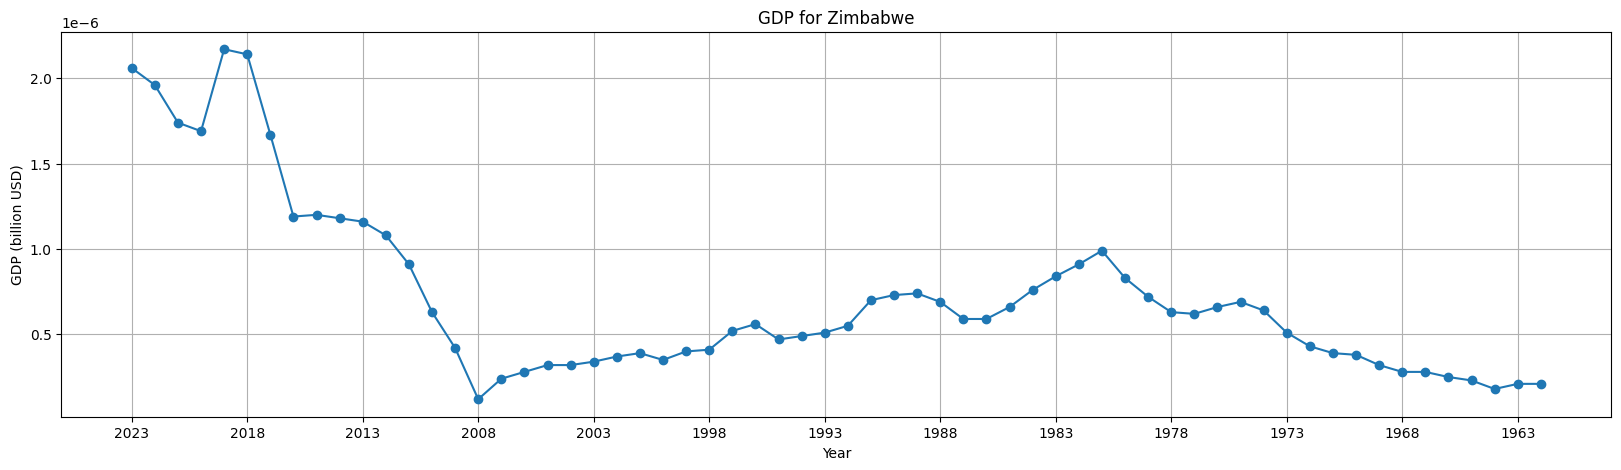

In [ ]:
import matplotlib.pyplot as plt

# Plot GDP data
plt.figure(figsize=(20, 5))
plt.plot(-df_gdp['year'], df_gdp['value'] / 1e9, marker='o')
# X-axis labels every 5 years
plt.xticks(df_gdp['year'][::5])
plt.title("GDP for Zimbabwe")
plt.xlabel("Year")
plt.ylabel("GDP (billion USD)")
plt.grid(True)
plt.show()


Data for Zimbabwe:
  country  year         value
0     ZWE  2023  9.266223e+09
1     ZWE  2022  1.301479e+10
2     ZWE  2021  7.846790e+09
3     ZWE  2020  8.803956e+09
4     ZWE  2019  8.236244e+09


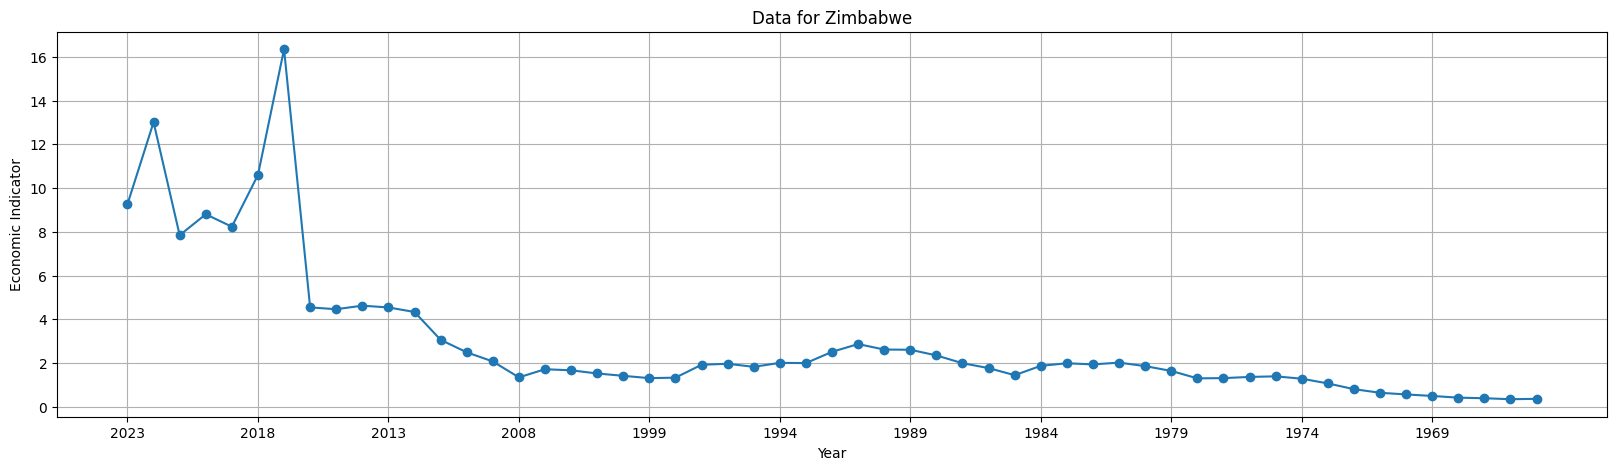

In [3]:
df_data = econ.get("ZWE", "IND_VALUE", "1960:2023")

if df_data is not None:
    print("\nData for Zimbabwe:")
    print(df_data.head())

plt.figure(figsize=(20, 5))
plt.plot(df_data['year'], df_data['value'] / 1e9, marker='o')
# X-axis labels every 5 years
plt.xticks(df_data['year'][::5])
plt.title("Data for Zimbabwe")
plt.xlabel("Year")
plt.ylabel("Economic Indicator")
plt.grid(True)
plt.show()